[]


/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


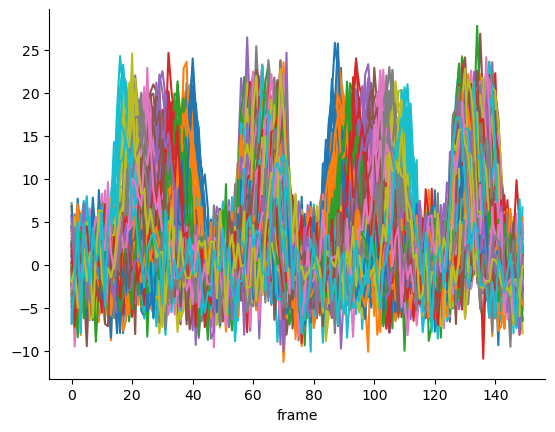

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import datetime
print(tf.config.list_physical_devices('GPU'))
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]
x, y = np.meshgrid(np.linspace(-.75, .75, 10), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 10))
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
data = model.simulate(noise=3)
data.plot(legend=False)
sns.despine()
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
model2 = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                      hrf_model=SPMHRFModel(tr=1.7))

bounds = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0, 100], 
}
bfitter = BPRF(model=model2, data=data, )
bfitter.add_priors_from_bounds(bounds)
n_vx = 9
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),

})

In [2]:
# bfitter.prep_for_fitting()

In [3]:

# # Test timing 
# print('Timing')

# start = datetime.datetime.now()
# a = bfitter.fit(
#     idx=[0], 
#     init_pars=init_pars,
#     num_results=100,     
    
#     #ols_pars,
#     # fixed_pars={'baseline' : 0.0}
# )
# print(datetime.datetime.now() - start)


In [4]:
cfitter = ParameterFitter(model, data, paradigm)
timenow = datetime.datetime.now()
grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 20),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)
print(datetime.datetime.now() - timenow)

Working with chunk size of 7407
Using correlation cost!


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: 0.78784/Best R2: 0.78784:  17%|█▋        | 169/1000 [00:05<00:26, 31.94it/s]

0:00:06.711681


In [ ]:
bfitter.mcmc_sampler[0]

In [ ]:
import corner
labels = ['x', 'y', 'sd', 'amplitude', 'baseline']
truths = [parameters.iloc[0,:][l] for l in labels]
_ = corner.corner(
    bfitter.mcmc_sampler[0].iloc[0:,:],
    labels=labels,
    truths=parameters.iloc[0,:]

    )

In [ ]:
truths

In [ ]:
from braincoder.utils.visualize import quick_plot
quick_plot(
    bfitter.model, 
    parameters=bfitter.mcmc_sampler[0].iloc[-1,:],
    data=data.iloc[:,0],
)
bfitter.mcmc_sampler[0].iloc[-1,:]
plt.gca().set_ylim(-.18, 1)
# quick_plot(
#     model2, 
#     parameters=parameters.iloc[1,:],
#     data=data.iloc[:,1],
# )

In [ ]:
bfitter.mcmc_sampler[0].iloc[50,:]

In [ ]:
parameters